In [3]:
import tensorflow as tf
from datasets import load_dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

ds = load_dataset("detection-datasets/fashionpedia")
EPOCHS = 20
initial_learning_rate = 0.0001

In [4]:
def preprocess_image(example):
    try:
        image = np.array(example['image'].convert('RGB'))
        if image.size == 0 or image.shape[0] <= 0 or image.shape[1] <= 0:
            return None

        image = tf.image.resize(image, [224, 224]).numpy()
        image = image / 255.0

        if len(example['objects']['bbox']) > 0:
            bbox = np.array(example['objects']['bbox'][0], dtype=np.float32)
        else:
            bbox = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32)

        height, width = example['height'], example['width']
        if height <= 0 or width <= 0:
            return None
        bbox = bbox / [width, height, width, height]

        if not np.isfinite(bbox).all():
            return None

        return {'image': image, 'bbox_output': bbox}
    except Exception:
        return None

In [5]:
def count_valid_examples(dataset):
    valid_count = 0
    for _ in (dataset):
        if preprocess_image(_) is not None:
            valid_count += 1
    return valid_count

In [6]:
def data_generator(dataset, batch_size=4):
    batch_images = []
    batch_bboxes = []
    for i, example in enumerate(dataset):
        result = preprocess_image(example)
        if result is not None:
            batch_images.append(result['image'])
            batch_bboxes.append(result['bbox_output'])
            if len(batch_images) == batch_size:
                yield (np.array(batch_images), np.array(batch_bboxes))
                batch_images = []
                batch_bboxes = []
    if batch_images: 
        yield (np.array(batch_images), np.array(batch_bboxes))

In [7]:
def configure_for_performance(ds):
    ds = ds.prefetch(tf.data.AUTOTUNE)
    for batch in ds.take(1):
        images, bboxes = batch
        if np.any(np.isnan(images)) or np.any(np.isnan(bboxes)):
            raise ValueError("NaN values detected in batch")
    return ds

In [8]:
def build_model(input_shape=(224, 224, 3), num_outputs=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_outputs, activation='sigmoid', name='bbox_output')
    ])
    model.summary()
    return model

In [9]:
train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(ds['train']),
    output_types=(tf.float32, tf.float32),
    output_shapes=(([None, 224, 224, 3], [None, 4]))
)

val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(ds['val']),
    output_types=(tf.float32, tf.float32),
    output_shapes=(([None, 224, 224, 3], [None, 4]))
)

I0000 00:00:1754024857.014229      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754024857.015073      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Number of valid training examples: 45623
Number of valid validation examples: 1158


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bbox_output (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,211,396 (99.99 MB)

 Trainable params: 26,211,396 (99.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1754025256.714733     141 service.cc:148] XLA service 0x7981e000eff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754025256.716575     141 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754025256.716601     141 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754025257.274698     141 cuda_dnn.cc:529] Loaded cuDNN version 90300


    5/11405 ━━━━━━━━━━━━━━━━━━━━ 6:44 35ms/step - loss: 0.0556 - mae: 0.2002

I0000 00:00:1754025262.459368     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11404/11405 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0423 - mae: 0.1606
Epoch 1: val_mae improved from inf to 0.16027, saving model to clothingtask5.weights.h5
11405/11405 ━━━━━━━━━━━━━━━━━━━━ 541s 47ms/step - loss: 0.0423 - mae: 0.1606 - val_loss: 0.0418 - val_mae: 0.1603
Epoch 2/20
    1/11405 ━━━━━━━━━━━━━━━━━━━━ 10:36:40 3s/step - loss: 0.0355 - mae: 0.1310

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_mae did not improve from 0.16027
11405/11405 ━━━━━━━━━━━━━━━━━━━━ 13s 868us/step - loss: 0.0355 - mae: 0.1310 - val_loss: 0.0417 - val_mae: 0.1603
Epoch 3/20
11404/11405 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0396 - mae: 0.1529
Epoch 3: val_mae improved from 0.16027 to 0.15621, saving model to clothingtask5.weights.h5
11405/11405 ━━━━━━━━━━━━━━━━━━━━ 525s 46ms/step - loss: 0.0396 - mae: 0.1529 - val_loss: 0.0404 - val_mae: 0.1562
Epoch 4/20
    1/11405 ━━━━━━━━━━━━━━━━━━━━ 3:12 17ms/step - loss: 0.0379 - mae: 0.1425
Epoch 4: val_mae did not improve from 0.15621
11405/11405 ━━━━━━━━━━━━━━━━━━━━ 9s 831us/step - loss: 0.0379 - mae: 0.1425 - val_loss: 0.0405 - val_mae: 0.1565
Epoch 5/20
11405/11405 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0382 - mae: 0.1489
Epoch 5: val_mae improved from 0.15621 to 0.15448, saving model to clothingtask5.weights.h5
11405/11405 ━━━━━━━━━━━━━━━━━━━━ 524s 46ms/step - loss: 0.0382 - mae: 0.1489 - val_loss: 0.0405 - val_mae: 0.1545
Epoch 6/

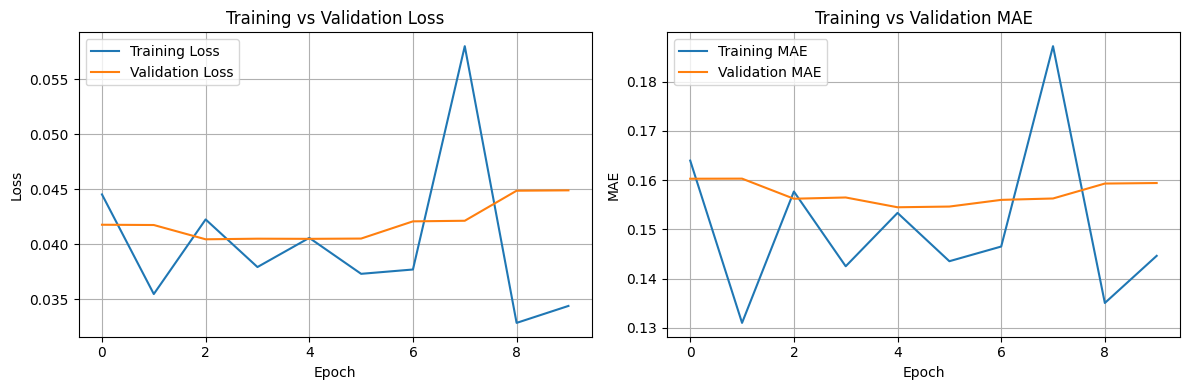

Final Training MAE: 0.1446
Final Validation MAE: 0.1594
Loading best weights.
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0397 - mae: 0.1535

Validation Loss: 0.0405
Validation MAE: 0.1545


In [ ]:
train_valid_count = count_valid_examples(ds['train'])
val_valid_count = count_valid_examples(ds['val'])
print(f"Number of valid training examples: {train_valid_count}")
print(f"Number of valid validation examples: {val_valid_count}")

batch_size = 4
steps_per_epoch = train_valid_count // batch_size
validation_steps = val_valid_count // batch_size

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

model = build_model()
model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss='mse',
    metrics=['mae']
)

checkpoint = ModelCheckpoint(
    '/kaggle/working/clothingtask5.weights.h5',
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping],
    verbose=1  
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

last_train_mae = history.history['mae'][-1]
last_val_mae = history.history['val_mae'][-1]
print(f"Final Training MAE: {last_train_mae:.4f}")
print(f"Final Validation MAE: {last_val_mae:.4f}")

print("Loading best weights.")
model.load_weights('/kaggle/working/clothingtask5.weights.h5')

val_loss = model.evaluate(val_ds, verbose=1)
print(f"\nValidation Loss: {val_loss[0]:.4f}")
print(f"Validation MAE: {val_loss[1]:.4f}")

model.save('/kaggle/working/clothingtask5.h5')